In [77]:
# type this command in gitbash/terminal: conda install -c conda-forge fbprophet
import pandas as pd
from fbprophet import Prophet
import datetime

In [78]:
df = pd.read_csv('raw_files/sale_prices_state.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.tail()

,Date,CA,TX,NY,FL,IL,PA,OH,MI,GA,...,NH,RI,MT,DE,SD,AK,ND,VT,DC,WY
286,2019-11-30,563523,209358,325925,248103,203907,195918,150953,173597,203623,...,291907,303184,283654.0,257899,206301,307886,236431.0,258948,633135,252517.0
287,2019-12-31,566433,209723,326646,248825,204058,196555,151551,174330,204290,...,293356,304444,284987.0,257775,207033,306078,236708.0,259558,634526,253571.0
288,2020-01-31,569813,210164,327360,249766,204302,197133,152229,175146,205044,...,294946,305755,286402.0,257647,207831,305820,236802.0,260280,637048,254531.0
289,2020-02-29,573975,210591,328101,250981,204527,197735,152916,175948,205955,...,296965,307296,287633.0,257723,208782,303294,237099.0,260677,639504,255456.0
290,2020-03-31,578267,211199,328677,252309,204839,198377,153593,176977,206804,...,299333,308658,288867.0,257521,209684,300073,237454.0,261265,640783,256089.0


In [79]:
# Must rename the Date column to ds and one state to y in order for fbprophet to work 
state = "TX"
df = df[["Date",state]]
df = df.rename(columns = {"Date": "ds", state: "y"})

In [80]:
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [81]:
## Trying to predict housing sales prices 3 years (730 days) into the future. Our dataset stops at 3/31/20. Now our model will predict up to 3/31/2021. 
future = model.make_future_dataframe(periods=1095)
future.tail()

,ds
1381,2023-03-27
1382,2023-03-28
1383,2023-03-29
1384,2023-03-30
1385,2023-03-31


In [82]:
forecast = model.predict(future)
forecast.to_csv(f'DataSets/{state}_Prediction.csv')
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1381,2023-03-27,248164.142749,238654.819823,258476.910886
1382,2023-03-28,248019.937670,238426.012029,258609.755526
1383,2023-03-29,247798.548485,238501.597822,258543.701903
1384,2023-03-30,247505.181344,238106.088000,258331.179045
1385,2023-03-31,247147.022286,237593.693183,257442.870360


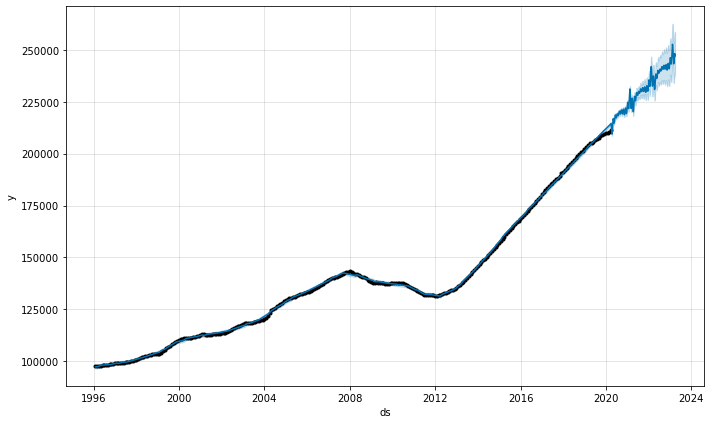

In [83]:
fig1 = model.plot(forecast)

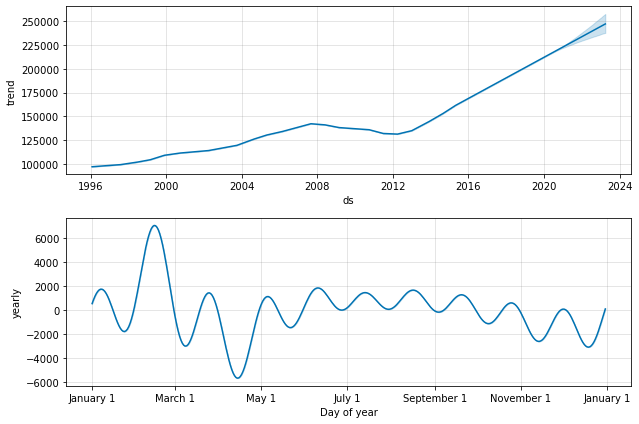

In [84]:
fig2 = model.plot_components(forecast)

In [85]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='8370 days', period='180 days', horizon = '365 days')
df_cv.to_csv(f'DataSets/{state}_Cross_Validation.csv')
df_cv
# Performing a cross validation: the training set is from 1/31/1996 - 4/1/2019 
# The goal is to forecast over a 365 days horizon: it would be from 4/30/2019 to 3/31/2020 

INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-04-01 00:00:00 and 2019-04-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-04-30,206596.710855,206231.509030,206990.766408,205377,2019-04-01
1,2019-05-31,207587.457471,207178.235019,207967.690161,205843,2019-04-01
2,2019-06-30,208577.505445,208155.955541,208990.009421,206423,2019-04-01
3,2019-07-31,209502.719225,209017.218018,210010.847348,207079,2019-04-01
4,2019-08-31,210393.777217,209885.178831,210977.469170,207699,2019-04-01
5,2019-09-30,211251.124478,210720.331947,211904.021634,208380,2019-04-01
6,2019-10-31,212227.429356,211573.126813,213026.330015,208865,2019-04-01
7,2019-11-30,213124.765171,212251.830356,214149.801337,209358,2019-04-01
8,2019-12-31,214168.209575,213022.085425,215397.404421,209723,2019-04-01
9,2020-01-31,215198.482999,213840.797298,216751.198351,210164,2019-04-01


In [86]:
# Analyzing prediction performance 
# MSE: Mean squared error 
# RMSE: Root mean squared error 
# MAE: Mean absolute error 
# MAPE: Mean absolute percent error 
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.to_csv(f'DataSets/{state}_Diagnostics.csv')
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,29 days,1.487695e+06,1219.710855,1219.710855,0.005939,0.005939,0.0
1,60 days,3.043132e+06,1744.457471,1744.457471,0.008475,0.008475,0.0
2,90 days,4.641894e+06,2154.505445,2154.505445,0.010437,0.010437,0.0
3,121 days,5.874415e+06,2423.719225,2423.719225,0.011704,0.011704,0.0
4,152 days,7.261824e+06,2694.777217,2694.777217,0.012974,0.012974,0.0
5,182 days,8.243356e+06,2871.124478,2871.124478,0.013778,0.013778,0.0
6,213 days,1.130593e+07,3362.429356,3362.429356,0.016099,0.016099,0.0
7,243 days,1.418852e+07,3766.765171,3766.765171,0.017992,0.017992,0.0
8,274 days,1.975989e+07,4445.209575,4445.209575,0.021196,0.021196,0.0
9,305 days,2.534602e+07,5034.482999,5034.482999,0.023955,0.023955,0.0


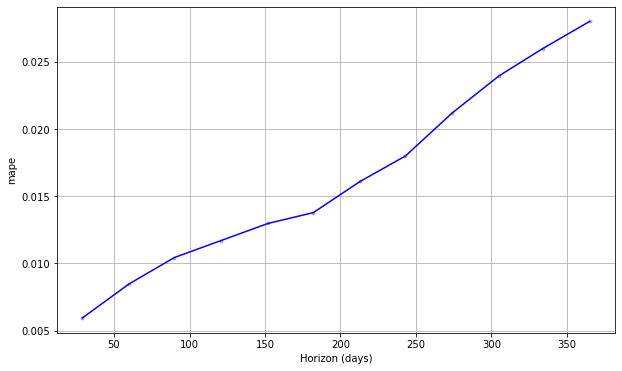

In [87]:
from fbprophet.plot import plot_cross_validation_metric
fig_mape = plot_cross_validation_metric(df_cv, metric='mape')

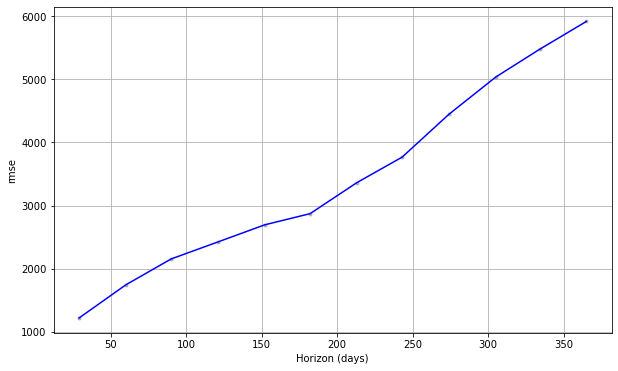

In [88]:
from fbprophet.plot import plot_cross_validation_metric
fig_rmse = plot_cross_validation_metric(df_cv, metric='rmse')

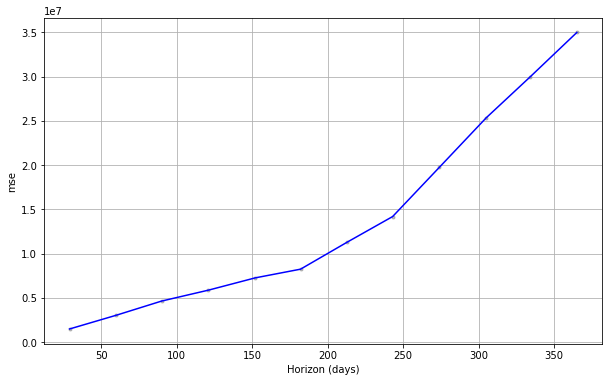

In [89]:
from fbprophet.plot import plot_cross_validation_metric
fig_mse = plot_cross_validation_metric(df_cv, metric='mse')